<h1>NFL Betting Project: Point Total Prediction Model</h1>

In [23]:
# import packages
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import shuffle

In [24]:
# import preprocessed game data csv file
data = pd.read_csv('nfl-transformed-game-data.csv', sep=',', encoding='unicode_escape')
# check for any missing values in data
print('Number of missing values in data: ' + str(sum(data.isnull().sum())))

Number of missing values in data: 0


In [25]:
indoor = data[['indoor_stadium']].to_numpy()
divisional = data[['divisional']].to_numpy()

for i in range(len(indoor)):
    if(indoor[i] == 0):
        indoor[i] = -1
    
for i in range(len(divisional)):
    if(divisional[i] == 0):
        divisional[i] = -1
        
data = data.drop(['indoor_stadium', 'divisional'], axis=1)
data['indoor_stadium'] = indoor
data['divisional'] = divisional

In [26]:
team_matchups_margin_o_u = data[['team_matchups_over']].to_numpy() - data[['team_matchups_under']].to_numpy()
team_matchups_margin_h_cov = data[['team_matchups_h_covered']].to_numpy() - data[['team_matchups_a_covered']].to_numpy()

data = data.drop(['team_matchups_over', 'team_matchups_under', 'team_matchups_h_covered', 'team_matchups_a_covered'], axis=1)
data['team_matchups_margin_o_u'] = team_matchups_margin_o_u
data['team_matchups_margin_h_cov'] = team_matchups_margin_h_cov

In [27]:
data = data.replace(['Bill Vinocich', 'Gene Stetatore', 'Al Riveron', 'Michael Carey', 'John Perry', 'Bradley Rogers', 
                     'Ronald Torbert'], 
                    ['Bill Vinovich', 'Gene Steratore', 'Alberto Riveron', 'Mike Carey', 'John Parry', 'Brad Rogers',
                    'Ron Torbert'])

In [28]:
X = data.drop(['o_u_result', 'home_covered_spread'], axis=1)
y = data['o_u_result']

<h2>Split Data</h2>

In [29]:
# Split data into 80/20 training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [30]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

<h2>Remove Correlated Features</h2>

In [31]:
corr_feats = []
corr_matrix = X_train.corr()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (abs(corr_matrix.iloc[i, j]) >= 0.90):
            col_name = corr_matrix.columns[i]
            corr_feats.append(col_name)

In [32]:
corr_feats

['home_off_pts_per_play',
 'away_off_pts_per_play',
 'home_def_pts_per_play',
 'away_def_pts_per_play',
 'home_off_pass_compl_rate',
 'away_off_pass_compl_rate',
 'home_def_pass_compl_rate',
 'away_def_pass_compl_rate']

In [33]:
X_train = X_train.drop(['home_off_pts_per_play',
 'away_off_pts_per_play',
 'home_def_pts_per_play',
 'away_def_pts_per_play',
 'home_off_pass_compl_rate',
 'away_off_pass_compl_rate',
 'home_def_pass_compl_rate',
 'away_def_pass_compl_rate'], axis=1)
X_test = X_test.drop(['home_off_pts_per_play',
 'away_off_pts_per_play',
 'home_def_pts_per_play',
 'away_def_pts_per_play',
 'home_off_pass_compl_rate',
 'away_off_pass_compl_rate',
 'home_def_pass_compl_rate',
 'away_def_pass_compl_rate'], axis=1)

<h2>Recursive Feature Elimination</h2>

In [34]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

In [35]:
encoder = TargetEncoder(min_samples_leaf=32, smoothing=2.0)

ridge = RidgeClassifierCV(alphas=[0.1, 1, 10, 50], scoring='balanced_accuracy', cv=kfold)

selector = RFECV(estimator=ridge, min_features_to_select=10, cv=kfold, scoring='balanced_accuracy', n_jobs=-1)

pipeline = Pipeline(steps=[('encode', encoder), ('scale', StandardScaler()), ('select', selector)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('encode',
                 TargetEncoder(cols=['stadium', 'referee', 'home_coach',
                                     'away_coach'],
                               min_samples_leaf=32, smoothing=2.0)),
                ('scale', StandardScaler()),
                ('select',
                 RFECV(cv=StratifiedKFold(n_splits=10, random_state=20, shuffle=True),
                       estimator=RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. , 50. ]),
                                                   cv=StratifiedKFold(n_splits=10, random_state=20, shuffle=True),
                                                   scoring='balanced_accuracy'),
                       min_features_to_select=10, n_jobs=-1,
                       scoring='balanced_accuracy'))])

In [36]:
feat_names = []
for i in range(len(selector.ranking_)):
    if(selector.ranking_[i]==1):
        feat_names.append(X_train.columns[i])

feat_names

['stadium',
 'referee',
 'wind_speed',
 'vegas_o_u',
 'home_coach',
 'away_coach',
 'away_off_pts_per_game',
 'away_off_adj_net_yds_per_att',
 'home_margin_o_u',
 'home_margin_ats',
 'home_pt_margin_o_u',
 'home_pt_margin_ats',
 'home_pt_margin']

<h2>NN Classifier</h2>

In [37]:
FS_x_train = X_train[feat_names]

encoder = TargetEncoder(min_samples_leaf=32, smoothing=2.0)

clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.005, early_stopping=True, 
                    max_iter=200, random_state=20)

pipeline = Pipeline(steps=[('encode', encoder), ('scale', StandardScaler()), ('classify', clf)])

search_space = [{'classify__hidden_layer_sizes': [(20,),(40,),(60,),(80,),(120,),(150,),(180,),(200,),
                                                  (40,20),(60,20),(80,20),(60,40),(80,40),(80,60),(150,20),(120,40),(200,80),
                                                  (60,40,20),(80,50,20),(180,80,30)],
                'classify__activation': ['identity', 'logistic', 'tanh', 'relu'],
                'classify__alpha': [0.0005, 0.005, 0.05, 0.5]}]

search = GridSearchCV(pipeline, search_space, scoring='balanced_accuracy', n_jobs=-1, refit=True, cv=kfold)

search.fit(FS_x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=20, shuffle=True),
             estimator=Pipeline(steps=[('encode',
                                        TargetEncoder(min_samples_leaf=32,
                                                      smoothing=2.0)),
                                       ('scale', StandardScaler()),
                                       ('classify',
                                        MLPClassifier(alpha=0.005,
                                                      early_stopping=True,
                                                      random_state=20))]),
             n_jobs=-1,
             param_grid=[{'classify__activation': ['identity', 'logistic',
                                                   'tanh', 'relu'],
                          'classify__alpha': [0.0005, 0.005, 0.05, 0.5],
                          'classify__hidden_layer_sizes': [(20,), (40,), (60,),
                                                           (80,), (120

In [38]:
search.best_estimator_

Pipeline(steps=[('encode',
                 TargetEncoder(cols=['stadium', 'referee', 'home_coach',
                                     'away_coach'],
                               min_samples_leaf=32, smoothing=2.0)),
                ('scale', StandardScaler()),
                ('classify',
                 MLPClassifier(activation='identity', alpha=0.05,
                               early_stopping=True, hidden_layer_sizes=(40, 20),
                               random_state=20))])

<h2>Final Classification Model</h2>

In [39]:
encoder = TargetEncoder(min_samples_leaf=32, smoothing=2.0)

scaler = StandardScaler()

clf = MLPClassifier(hidden_layer_sizes=(40,20), activation='identity', alpha=0.05, early_stopping=True, 
                    max_iter=200, random_state=20)

FS_x_train = X_train[feat_names]
FS_x_test = X_test[feat_names]

encoder.fit(FS_x_train, y_train)
x_trn = encoder.transform(FS_x_train)
x_tst = encoder.transform(FS_x_test)

scaler.fit(x_trn)
x_trn = scaler.transform(x_trn)
x_tst = scaler.transform(x_tst)

clf.fit(x_trn, y_train)
train_pred_values = clf.predict(x_trn)
test_pred_values = clf.predict(x_tst)

train_acc = balanced_accuracy_score(np.ravel(y_train), train_pred_values)
test_acc = balanced_accuracy_score(np.ravel(y_test), test_pred_values)

print('Training Set Balanced Accuracy: ' + str(train_acc))
print('Test Set Balanced Accuracy: ' + str(test_acc))

Training Set Balanced Accuracy: 0.6018973933867551
Test Set Balanced Accuracy: 0.5319756238558628


<h2>Model Simulation (267 Games)</h2>

In [40]:
# number of simulations to run
num_simulations = 100

# starting bankroll ($)
starting_bankroll = 10000

# size of each bet (as fraction of bankroll)
bet_size_frac = 0.05

# number of bets after which bet sizes are updated (to bet_size_frac)
n_update = 10

Starting Bankroll: $10000
Avg Ending Bankroll: $12082.77
Bet Win %: 0.5331
Min Ending Bankroll: $1246.17
Max Ending Bankroll: $40664.42
Avg Bet Size: $563.39
% Exceeded 2x (Above $20,000): 18
Ending Bankrolls: [10878.22, 6962.28, 14010.46, 4014.91, 5158.81, 19880.63, 8608.32, 8569.37, 5163.11, 7479.93, 8940.23, 7255.14, 2125.83, 37108.3, 26007.55, 2708.73, 6016.47, 20579.29, 11950.71, 7870.49, 4314.46, 17955.76, 10936.6, 6927.24, 7829.31, 6433.39, 6542.31, 14428.0, 9538.77, 2098.99, 12624.25, 7596.24, 14863.26, 14787.71, 3967.35, 38149.62, 17785.53, 2709.99, 5743.77, 5997.21, 19096.4, 4512.1, 9390.04, 11284.37, 14949.61, 15783.35, 9753.83, 3280.93, 4294.64, 7788.88, 5608.97, 40433.36, 8155.53, 6555.03, 6211.36, 31985.47, 6025.99, 5393.85, 6852.9, 7644.72, 5116.0, 2326.45, 3823.78, 20758.6, 18692.79, 1246.17, 7600.04, 11638.98, 5942.54, 2509.92, 22159.0, 23968.99, 11659.37, 3229.13, 18207.72, 8622.89, 22143.17, 3274.59, 8531.67, 4810.63, 20693.76, 22151.9, 23406.78, 6903.55, 6699.67, 17

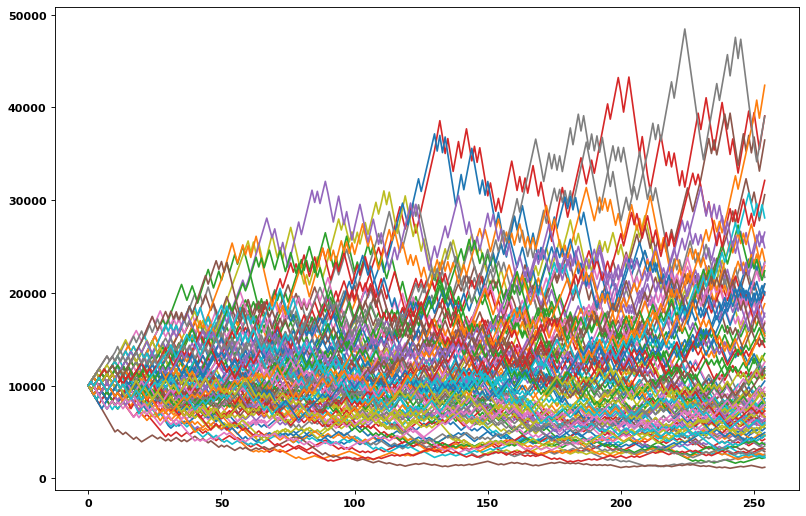

In [41]:
plt.figure(figsize=(12, 8), dpi=80)

ending_bankrolls = []
all_bet_results = []
all_bet_sizes = []
exceeded_2x = []

for n in range(num_simulations):
    
    actual_s, pred_s = shuffle(np.ravel(y_test), test_pred_values)
    
    i = -1
    bankroll = starting_bankroll
    bet_size = round(bankroll*bet_size_frac, 2)

    bet_ind = []
    bankroll_lst = []
    
    stop = False
    while((i+1 < 255) and (stop == False)):
        i += 1
        bet_ind.append(i)
        bankroll_lst.append(bankroll)
        all_bet_sizes.append(bet_size)

        if(pred_s[i] == actual_s[i]):
            winnings = round(bet_size*0.909091, 2)
            bankroll += winnings
            all_bet_results.append(1)
        else:
            bankroll -= bet_size
            all_bet_results.append(0)
        
        bankroll = round(bankroll, 2)

        if((i+1) % n_update == 0):
            bet_size = round(bankroll*bet_size_frac, 2)

        if((bankroll<= bet_size)):
            stop = True
    
    ending_bankrolls.append(bankroll)
    
    if(bankroll > 2*starting_bankroll):
        exceeded_2x.append(1)
    
    plt.plot(bet_ind, bankroll_lst)

print('Starting Bankroll: $' + str(starting_bankroll))
print('Avg Ending Bankroll: $' + str(round(sum(ending_bankrolls)/len(ending_bankrolls), 2)))
print('Bet Win %: ' + str(round(sum(all_bet_results) / len(all_bet_results), 4)))
print('Min Ending Bankroll: $' + str(min(ending_bankrolls)))
print('Max Ending Bankroll: $' + str(max(ending_bankrolls)))
print('Avg Bet Size: $' + str(round(sum(all_bet_sizes) / len(all_bet_sizes), 2)))
print('% Exceeded 2x (Above $20,000): ' + str(sum(exceeded_2x)))
print('Ending Bankrolls: ' + str(ending_bankrolls))